In [166]:
import numpy as np
import pandas as pd
import glob
import os
from omegaconf import OmegaConf
import skimage
from tqdm.notebook import tqdm, trange

In [167]:
# Define parameters here
start_date = "2024-00-00"
max_images = 424242
output_path = "../outputs"
target_path = "../data/raw/train_kelp/"

In [168]:
# Search for suitable output folders
folders = []
confs = dict()
for day_folder in glob.glob(os.path.join(output_path, "*/")):
    if day_folder.split(os.sep)[-2] < start_date:
        continue       
    for timestamp_folder in glob.glob(os.path.join(day_folder, "*/")):
        if not os.path.exists(os.path.join(timestamp_folder, "preds")):
            continue
        
        # read the .hydra/config.yaml file with omegaconf into a dictionary
        with open(os.path.join(timestamp_folder, ".hydra", "config.yaml"), "r") as f:
            cfg = OmegaConf.load(f)
            
        if "test_size" not in cfg or cfg.test_size != 0.2:
            continue
        
        confs[timestamp_folder] = cfg            
        print(timestamp_folder)
        folders.append(timestamp_folder)
print(f"Found {len(folders)} suitable folders")

../outputs\2024-01-26\16-14-25\
../outputs\2024-01-26\17-26-33\
../outputs\2024-01-26\17-26-48\
../outputs\2024-01-26\21-26-38\
../outputs\2024-01-26\21-47-29\
../outputs\2024-01-26\23-17-01\
../outputs\2024-01-27\11-47-50\
../outputs\2024-01-27\12-26-05\
../outputs\2024-01-27\12-26-45\
../outputs\2024-01-27\16-07-29\
../outputs\2024-01-27\16-52-01\
../outputs\2024-01-27\18-12-03\
../outputs\2024-01-27\19-24-34\
../outputs\2024-02-14\09-43-04\
../outputs\2024-02-14\14-26-02\
../outputs\2024-02-14\14-45-28\
../outputs\2024-02-18\17-34-13\
Found 17 suitable folders


In [169]:
# Filter out folders with identical configurations
unique_confs = dict()
for folder, conf in confs.items():
    if conf not in unique_confs.values():
        unique_confs[folder] = conf
folders = list(unique_confs.keys())
print(f"Remaining folders: {len(folders)}")

Remaining folders: 16


In [170]:
# Read the filenames inside the first folder
filenames = glob.glob(os.path.join(folders[0], "preds", "*.tif"))
image_names = [os.path.basename(f)[:-9] for f in filenames]

In [171]:
# Create a name based on the config
names = dict()
for folder in folders:
    conf = confs[folder]
    name = conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].model.model._target_.split(".")[-1]
    if name == "Unet":
        name = f"{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].model.model.encoder_name}-{name}"
    name += f"-f{len(conf.model.model_loop_pipeline.pretrain_pipeline.pretrain_steps[1].columns)}"
    name += f"-bs{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].batch_size}"
    name += f"-e{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].epochs}"
    name += f"-{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].criterion._target_.split('.')[-1]}"
    names[folder] = name
for folder, name in names.items():
    print(folder, name)

../outputs\2024-01-26\16-14-25\ vgg11-Unet-f7-bs16-e50-KelpWeightedBatchLoss
../outputs\2024-01-26\17-26-33\ vgg11-Unet-f3-bs16-e50-KelpWeightedBatchLoss
../outputs\2024-01-26\17-26-48\ vgg11-Unet-f3-bs16-e50-KelpWeightedBatchLoss
../outputs\2024-01-26\21-26-38\ resnext50_32x4d-Unet-f3-bs16-e50-KelpWeightedBatchLoss
../outputs\2024-01-26\21-47-29\ vgg11-Unet-f3-bs16-e50-KelpWeightedBatchLoss
../outputs\2024-01-26\23-17-01\ resnext50_32x4d-Unet-f3-bs16-e50-KelpWeightedBatchLoss
../outputs\2024-01-27\11-47-50\ vgg11-Unet-f3-bs16-e50-KelpWeightedBatchLoss
../outputs\2024-01-27\12-26-05\ vgg11-Unet-f3-bs16-e50-KelpWeightedBatchLoss
../outputs\2024-01-27\12-26-45\ vgg11-Unet-f3-bs16-e50-DiceLoss
../outputs\2024-01-27\16-07-29\ vgg11-Unet-f3-bs64-e50-DiceLoss
../outputs\2024-01-27\16-52-01\ vgg11-Unet-f3-bs16-e50-DiceLoss
../outputs\2024-01-27\19-24-34\ vgg11-Unet-f3-bs16-e75-DiceLoss
../outputs\2024-02-14\09-43-04\ SwinUNETR-f18-bs16-e75-DiceLoss
../outputs\2024-02-14\14-26-02\ SwinUNETR-f1

In [172]:
# Take the first max_images images
image_selection = image_names[:min(max_images, len(image_names))]

In [173]:
# Load the target tiffs into an array
targets = []
for image_name in tqdm(image_selection):
    target = skimage.io.imread(os.path.join(target_path, f"{image_name}_kelp.tif"))
    targets.append(target)
targets = np.array(targets).flatten()

  0%|          | 0/1127 [00:00<?, ?it/s]

In [174]:
# Load the predictions into an array
predictions = dict()
for folder in tqdm(folders):
    preds = []
    for image_name in image_selection:
        pred = skimage.io.imread(os.path.join(folder, "preds", f"{image_name}_pred.tif"))
        preds.append(pred)
    predictions[folder] = np.array(preds).flatten()

  0%|          | 0/16 [00:00<?, ?it/s]

In [175]:
# Calculate the dice scores and square error
dice_scores = dict()
square_errors = dict()
for folder, preds in tqdm(predictions.items()):
    preds = preds > 0.5
    dice_scores[folder] = 2 * np.sum(targets * preds) / (np.sum(targets) + np.sum(preds))   
    square_errors[folder] = np.mean((targets - preds) ** 2)

  0%|          | 0/16 [00:00<?, ?it/s]

In [176]:
# Remove all models with dice score below 0.6
folders = [folder for folder in folders if dice_scores[folder] > 0.6]
print(f"Remaining models: {len(folders)}")

Remaining models: 14


In [177]:
# Sort the folders by dice score
folders = sorted(folders, key=lambda folder: dice_scores[folder], reverse=True)

In [178]:
# Create a dataframe with the results
df = pd.DataFrame({
    "name": [names[folder] for folder in folders],
    "dice_score": [dice_scores[folder] for folder in folders],
    "square_error": [square_errors[folder] for folder in folders]
})

In [179]:
# Create a scatterplot with plotly express
import plotly.express as px
fig = px.scatter(df, x="dice_score", y="square_error", text="name")
fig.show()

In [180]:
# Step 1 of the algorithm, compute error, error mean per base model, and a covariance matrix
errors = np.array([predictions[folder] - targets for folder in folders])
error_means = np.mean(errors, axis=1)
covariance_matrix = np.cov(errors, bias=True)
corr = np.corrcoef(errors)

In [181]:
# Step 2. Define a function to estimate the squared error of the ensemble
def ensemble_error(selection, error_means, covariance_matrix):
    selection = np.array(selection) > 0.5
    return np.mean(error_means[selection])**2 + np.mean(covariance_matrix[selection][:, selection])

In [182]:
# Compute the actual error for comparison
def true_error(selection, errors):
    selection = np.array(selection) > 0.5
    return np.mean(np.mean(errors[selection],axis=0)**2)

In [183]:
# Use timeit to compare the two methods
import timeit
print(f"{timeit.timeit(lambda: ensemble_error(np.ones(len(folders)), error_means, covariance_matrix), number=2):.5}s")
print(f"{timeit.timeit(lambda: true_error(np.ones(len(folders)), errors), number=2):.5}s")

0.0001391s
4.0771s


In [184]:
# Step 3. Go through all possible combinations of models and find the best one
limit = np.inf 
best_error = np.inf
best_selection = None
for i in trange(1,min(2**len(folders),limit)):
    selection = [int(x) for x in bin(i)[2:].zfill(len(folders))]
    err = ensemble_error(selection, error_means, covariance_matrix)
    if err < best_error:
        best_error = err
        best_selection = selection
print("Best square error:", best_error)
print("Confirmation:", true_error(best_selection, errors))
print("Recommended ensemble:", best_selection)
# list the names of the models in the ensemble
for i in range(len(folders)):
    if best_selection[i] > 0.5:
        print(names[folders[i]])

  0%|          | 0/16383 [00:00<?, ?it/s]

Best square error: 0.003159933242431132
Confirmation: 0.0031599398
Recommended ensemble: [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]
SwinUNETR-f18-bs16-e75-DiceLoss
SwinUNETR-f18-bs16-e75-DiceLoss
SwinUNETR-f18-bs16-e75-DiceLoss
vgg13-Unet-f6-bs16-e75-DiceLoss
vgg11-Unet-f3-bs16-e50-DiceLoss
vgg11-Unet-f3-bs64-e50-DiceLoss
vgg11-Unet-f3-bs16-e50-DiceLoss
resnext50_32x4d-Unet-f3-bs16-e50-KelpWeightedBatchLoss


In [185]:
simple_selection = np.array([1,1,1,1] + [0]*(len(folders)-4))
print(f"Error (lower is better): Optimised: {best_error:.5f}, simple ensemble: {true_error(simple_selection, errors):.5f}, best model: {true_error([1]+[0]*(len(folders)-1), errors):.5f}")

# compute the dice score for the best and the simple selection ensembles
best_preds = np.mean([predictions[folders[i]] for i in range(len(folders)) if best_selection[i] > 0.5], axis=0) > 0.5
simple_preds = np.mean([predictions[folders[i]] for i in range(len(folders)) if simple_selection[i] > 0.5], axis=0) > 0.5
best_dice = 2 * np.sum(targets * best_preds) / (np.sum(targets) + np.sum(best_preds))
simple_dice = 2 * np.sum(targets * simple_preds) / (np.sum(targets) + np.sum(simple_preds))
print(f"Dice (higher is better): Optimised: {best_dice:.5f}, simple ensemble: {simple_dice:.5f}, best model: {dice_scores[folders[0]]:.5f}")

Error (lower is better): Optimised: 0.00316, simple ensemble: 0.00337, best model: 0.00349
Dice (higher is better): Optimised: 0.70763, simple ensemble: 0.70782, best model: 0.70847


C:\Users\EmielW\AppData\Local\Temp\ipykernel_25280\3984676236.py:4: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



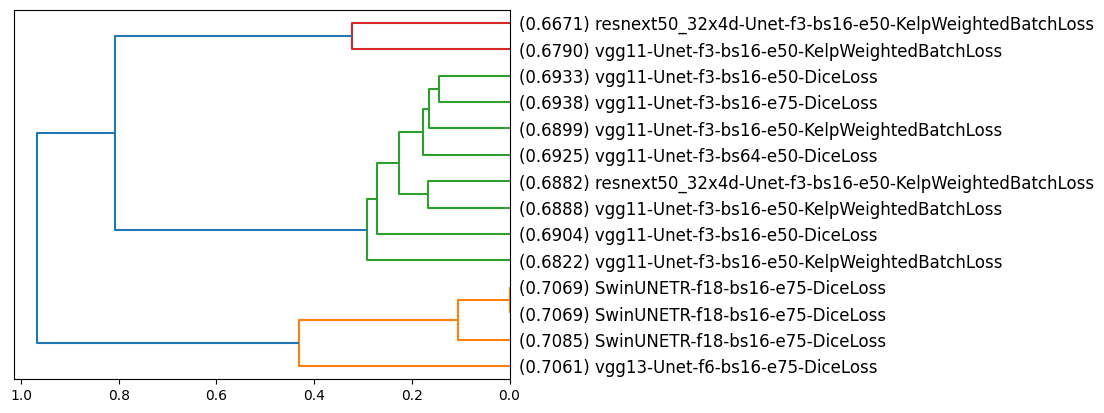

In [186]:
# Treat the correlation as a distance and use hierarchical clustering to group the models
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
dendrogram = sch.dendrogram(sch.linkage(1 - corr, method='ward'), labels=[f"({dice_scores[folder]:.4f}) {names[folder]}" for folder in folders], orientation="left")
# add the names of the models to the x-axis
plt.show()

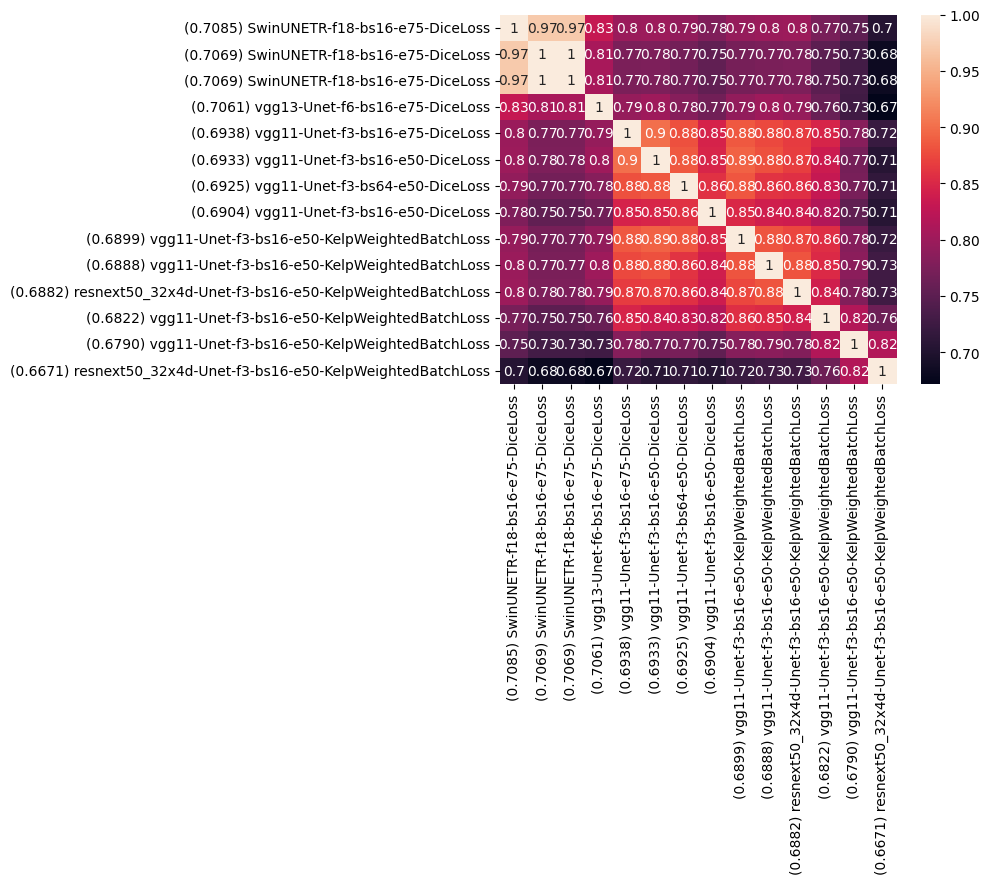

In [187]:
# show the correlation matrix heatmap
import seaborn as sns
sns.heatmap(corr, xticklabels=[f"({dice_scores[folder]:.4f}) {names[folder]}" for folder in folders], yticklabels=[f"({dice_scores[folder]:.4f}) {names[folder]}" for folder in folders], annot=True)
plt.show()